In [1]:
from __future__ import annotations
from copy import deepcopy
from time import perf_counter
import sys
sys.path.insert(0,'/content/drive/MyDrive/zad3')
from two_player_games.games import connect_four as cf
from typing import Tuple, List, Optional

INFINITY = 2000000000
WIN_LENGTH = 4



class MinMaxSolver:

    def __init__(self, game: cf.ConnectFour):
        self.game = game

    def get_fields(self) -> List[List[int]]:
        return self.game.state.fields

    def get_current_other_player(self) -> Tuple[cf.Player, cf.Player]:
        player = self.game.get_current_player()
        other = self.game.second_player if self.game.first_player.char == player.char else self.game.first_player
        return player, other

    def after_move(self, move: cf.Move) -> MinMaxSolver:
        new_minimax = MinMaxSolver(deepcopy(self.game))
        new_minimax.game.make_move(move)
        return new_minimax

    def in_bounds(self, x: int, y: int) -> bool:
        fields = self.get_fields()
        x_max = len(fields) - 1
        y_max = len(fields[0]) - 1
        return 0 <= x <= x_max and 0 <= y <= y_max

    def game_final_score(self) -> Optional[int]:
        """ If the game is finished, return score from the perspective of the player who would have the next move"""
        if self.game.is_finished():
            if self.game.get_winner() is None:
                return 0
            if self.game.get_winner().char == self.get_current_other_player()[0].char:
                return INFINITY
            return -INFINITY
        return None

    def eval_pos_points(self, direction: Tuple[int, int], perspective: cf.Player, coordinates: Tuple[int, int]) -> int:
        """
        Look for situations where a player's row of tokens can be expanded. Add old_length^2 to score for each such row.
        Ignore rows that cannot be expanded all the way to WIN_LENGTH.
        """
        fields = self.get_fields()
        length, extra_length = 1, 0

        x = coordinates[0] + direction[0]
        y = coordinates[1] + direction[1]
        while self.in_bounds(x, y) and fields[x][y] is None:
            extra_length += 1
            x += direction[0]
            y += direction[1]

        if extra_length == 0:
            return 0

        x = coordinates[0] - direction[0]
        y = coordinates[1] - direction[1]
        while self.in_bounds(x, y) and fields[x][y] is not None and fields[x][y].char == perspective.char:
            length += 1
            x -= direction[0]
            y -= direction[1]
            if length == WIN_LENGTH:
                return INFINITY

        if length + extra_length < WIN_LENGTH:
            return 0
        return length ** 2

    def evaluate_position_onesided(self, perspective: cf.Player) -> int:
        if self.game_final_score() is not None:
            if perspective.char == self.get_current_other_player()[0].char:
                return self.game_final_score()
            return -self.game_final_score()
        fields = self.get_fields()
        value = 0

        for x, column in enumerate(fields):
            for y, player in enumerate(column):
                if player is not None and player.char == perspective.char:
                    combinations = [(0, 1), (1, 1), (1, 0), (1, -1), (-1, -1), (-1, 0), (-1, 1)]  # no (0, -1)
                    for combination in combinations:
                        points = self.eval_pos_points(combination, perspective, (x, y))
                        if points == INFINITY:
                            return points
                        value += points
        return value

    def evaluate_position(self) -> int:
        if self.game_final_score() is not None:
            return self.game_final_score()
        player, other = self.get_current_other_player()
        return self.evaluate_position_onesided(player) - self.evaluate_position_onesided(other)

    def get_best_move(self) -> Optional[Tuple[cf.Move, int]]:
        best = None  # None or (move, value)
        for move in self.game.get_moves():
            new_minimax = self.after_move(move)
            # negated score and reversed player/other, because new_minimax has the opponent's perspective
            other, player = new_minimax.get_current_other_player()

            value = new_minimax.evaluate_position_onesided(player)
            if value == INFINITY:
                return move, INFINITY
            value -= new_minimax.evaluate_position_onesided(other)

            if best is None or value > best[1]:
                best = move, value
        return best

    def is_valid_move(self, col_index: int) -> bool:
        return self.get_fields()[col_index][-1] is None

    def minimax(self, depth: int, alpha: int = -INFINITY, beta: int = INFINITY, is_maximizing_player: bool = True)\
            -> Optional[Tuple[Optional[cf.Move], int]]:
        """
        Returns column index and score. Initialize alpha with None to disable alpha/beta pruning.
        None: ignore this move
        None, value: the last move is unknown, but this isn't the highest call depth, so it's irrelevant
        move, value: normal return
        """

        if self.game_final_score() is not None:
            return None, self.game_final_score()
        if depth == 0:
            return None, self.evaluate_position()

        best = None
        for move in self.game.get_moves():
            result = self.after_move(move).minimax(depth-1, alpha, beta, not is_maximizing_player)
            if result is None:
                continue
            _, value = result
            value = -value  # min analyzes from their perspective

            if best is None or value > best[1]:
                best = move, value
            if best[1] == INFINITY:
                return best

            if alpha is not None:
                if is_maximizing_player and alpha < value:
                    alpha = value
                if not is_maximizing_player and beta > -value:
                    beta = -value
                if beta < alpha:
                    return None

        if best is None:
            return None, self.evaluate_position()
        return best

    def move(self, depth: int, alpha: int = -INFINITY, beta: int = INFINITY, is_maximizing_player: bool = True) -> None:
        self.game.make_move(self.minimax(depth, alpha, beta, is_maximizing_player)[0])


Implementacja metody minimax z mozliwością korzystania z odcięcia alfa-beta. Heurystyka przegląda pionki danego gracza i przyznaje punkty za każdy rząd pionków, które dałoby się rozbudować do pełnej czwórki (punkty = obecna_długość^2)

In [2]:
def print_cell(value, col_width):
    print(f"{value:^{col_width}}|", end='')


def print_table(table, col_width):
    assert col_width >= 3, "Columns need at least 3 width"
    max_width = len(table)
    print_cell('A\\B', col_width)

    for x in range(max_width):
        print_cell(x+1, col_width)
    print()

    for x, row in enumerate(table):
        print_cell(x + 1, col_width)
        for cell in row:
            print_cell(cell, col_width)
        print()


def benchmark(max_depth: int) -> None:
    winners = [['X' for _ in range(max_depth)] for _ in range(max_depth)]
    times = ["" for _ in range(max_depth)]
    for i in range(max_depth):
        for j in range(max_depth):
            game = cf.ConnectFour(first_player=cf.Player('A'), second_player=cf.Player('B'))
            time_minimax, time_ab = 0, 0

            while not game.is_finished():
                start = perf_counter()
                game.make_move(MinMaxSolver(game).minimax(i + 1, None)[0])
                stop = perf_counter()
                time_minimax += stop - start
                if not game.is_finished():
                    start = perf_counter()
                    game.make_move(MinMaxSolver(game).minimax(j + 1)[0])
                    stop = perf_counter()
                    time_ab += stop - start

            winners[i][j] = game.get_winner().char if game.get_winner() is not None else '0'
            if i == j:
                times[i] = str(round(time_minimax, 2)) + " - " + str(round(time_ab, 2))

    print_table(winners, 3)
    print()
    print("Times: minimax - alphabeta")
    for x in range(len(times)):
        print(x + 1, ':', times[x])

Funkcja, która testuje działanie algorytmu Minimax - pokazuje wyniki dla różnych głębokości przeszukiwania u graczy i porównuje czasy z odcięciem i bez niego.

In [3]:
benchmark(4)

A\B| 1 | 2 | 3 | 4 |
 1 | A | B | A | B |
 2 | A | B | 0 | A |
 3 | A | A | A | B |
 4 | A | B | B | 0 |

Times: minimax - alphabeta
1 : 0.01 - 0.01
2 : 0.33 - 0.24
3 : 0.42 - 0.18
4 : 13.69 - 4.54


Wyniki z większych głębokości:

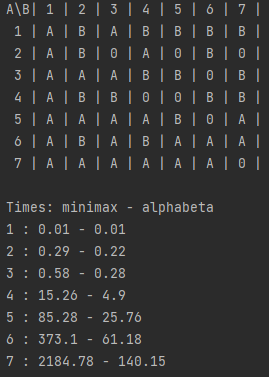

Ze względu na to, że heurystyka tylko przybliża jakość pozycji, a przeszukiwanie nie analizuje wszystkiego do końca gry, zwiększenie głębokości nie gwarantuje wygranej. Można jednak zauważyć, że zwiększa ono na nie szansę (lewy dolny a prawy górny róg).

Czas wykonania dla obu wersji (w sekundach) jest początkowo zbliżony, bo algorytm alfa-beta nie ma zbyt wiele do obcinania. Wraz ze zwiększeniem głębi oszczędność czasu staje się zdecydowanie większa.

Przykładowa rozgrywka, gdzie ruchy dla obu stron podaje algorytm:

In [4]:
game = cf.ConnectFour()
solver = MinMaxSolver(game)
while not game.is_finished():
    print(game)
    move, value = solver.minimax(4)
    print("Optimal found column:", move.column, "offering value", value)
    solver.game.make_move(move)
print(game)

Current player: 1
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
Optimal found column: 3 offering value 0
Current player: 2
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][1][ ][ ][ ]
Optimal found column: 3 offering value -7
Current player: 1
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][2][ ][ ][ ]
[ ][ ][ ][1][ ][ ][ ]
Optimal found column: 3 offering value -1
Current player: 2
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][1][ ][ ][ ]
[ ][ ][ ][2][ ][ ][ ]
[ ][ ][ ][1][ ][ ][ ]
Optimal found column: 3 offering value -9
Current player: 1
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][2][ ][ ][ ]
[ ][ ][ ][1][ ][ ][ ]
[ ][ ][ ][2][ ][ ][ ]
[ ][ ][ ][1][ ][ ][ ]
Optimal found column: 6 offering value -4
Current player: 2
[ ][ ][ ][ ][ ][ ][ ]
[